# Анализ данных

Для обучения был предоставлен датасет [ru_turbo_saiga](https://huggingface.co/datasets/IlyaGusev/ru_turbo_saiga), содержащий переписки на русском языке
<div align="center"><img src="https://github.com/droyti46/T-Bank-Junior-Task/blob/main/img/chat.png?raw=true" width="700px" style="border-radius: 20px;"></div>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/tbank

/content/drive/MyDrive/tbank


In [3]:
! pip install datasets jsonlines

In [55]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from transformers import pipeline
from datasets import load_dataset

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm, trange

In [4]:
# Загрузим датасет
dataset = load_dataset('IlyaGusev/ru_turbo_saiga')
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['messages', 'seed', 'source', 'model_name'],
        num_rows: 37731
    })
})


In [6]:
# Выведем для примера первую строку из датасета
dataset['train'][0]

{'messages': {'role': ['user', 'bot', 'user', 'bot'],
  'content': ['Мне нужно найти название фильма. В нем детей из детдомов набирают в группу для спец операций. Ты можешь мне помочь?',
   'Конечно. Навскидку я могу предложить несколько фильмов. Но, скорее всего, ты ищешь фильм под названием "Сиротский батальон" (англ. "The Little Bastards"). Эту картина, снятая в 2003 году, рассказывает о группе детей совершающих различные военные миссии, посланные на линию фронта.',
   'Да, спасибо. Извини, не было времени на поиск поисковиком. А есть ли другие фильмы на эту тему?',
   'Конечно. Есть еще один фильм, который может заинтересовать тебя. Он называется "Солдаты неудачи" (англ. "Toy Soldiers"). В этом фильме подростки из интернатной школы похищаются террористами, и вынуждены сражаться за свою жизнь. Этот фильм был выпущен в 1991 году.']},
 'seed': 'Как называется фильм в котором детей из детдомв набирают в группу для спец операций??',
 'source': 'yandex_q',
 'model_name': 'gpt-3.5-turbo'}

In [7]:
dataset['train'][0]['messages']['content'][0]

'Мне нужно найти название фильма. В нем детей из детдомов набирают в группу для спец операций. Ты можешь мне помочь?'

При анализе датасета было обнаружено, что в нем есть неправильные данные. То есть данные, в которых нет контента. Например, мы можем вывести несколько таких запросов из первых 10000 строк данных

In [8]:
for i in range(len(dataset['train']))[:10000]:
    try:
        dataset['train'][i]['messages']['content'][0]
    except IndexError:
        print(dataset['train'][i])

{'messages': {'role': [], 'content': []}, 'seed': 'Сколько всего серий в 5 сезоне "Молодежки"?', 'source': 'yandex_q', 'model_name': 'gpt-3.5-turbo'}
{'messages': {'role': [], 'content': []}, 'seed': 'Boost 1.71 Получить io_context из basic_socket', 'source': 'ru_stackoverflow', 'model_name': 'gpt-3.5-turbo'}
{'messages': {'role': [], 'content': []}, 'seed': 'Как подружить AJAX в паралели с загрузкой страницы?', 'source': 'habr_qna', 'model_name': 'gpt-3.5-turbo'}
{'messages': {'role': [], 'content': []}, 'seed': 'Как не бояться воды?', 'source': 'yandex_q', 'model_name': 'gpt-3.5-turbo'}
{'messages': {'role': [], 'content': []}, 'seed': 'Подскажите, пожалуйста, как мне найти оригинальные крепления на бампере для оригинального парктроника KIA RIO 3 дорестайлинг?', 'source': 'yandex_q', 'model_name': 'gpt-3.5-turbo'}
{'messages': {'role': [], 'content': []}, 'seed': 'ReactJS: Как присвоить переменным результат fetch(список объектов)?', 'source': 'habr_qna', 'model_name': 'gpt-3.5-turbo'

In [6]:
# Для дальнейшего анализа соберем все первые запросы в список
train = dataset['train']
prompts = [train[i]['messages']['content'][0] for i in trange(len(train)) if train[i]['messages']['content']]

100%|██████████| 37731/37731 [00:14<00:00, 2659.48it/s]


In [7]:
prompts[:10]

['Мне нужно найти название фильма. В нем детей из детдомов набирают в группу для спец операций. Ты можешь мне помочь?',
 'Я слышал, что Петр I ввёл крепостное право в России после своей поездки в Европу. Это правда?',
 'Я хотел бы узнать больше о том, как использовать счётчики для проверки результата.',
 'Я хочу добавить 4 гб оперативной памяти на свой ноутбук ASUS FX570UD-DM148T. Какую лучше взять?',
 'Я хочу настроить aiogram бота и не знаю, как правильно построить архитектуру файлов для него. Можете помочь?',
 'Я плохо разбираюсь в том, как находить верную информацию в интернете. Можешь мне объяснить, как это делается?',
 'Я хочу создать прозрачный блок на сайте с эффектом blur. Как это сделать?',
 'Я хочу узнать, как вы находите в себе терпение, чтобы прочитать все книги, которые считаете необходимыми для прочтения?',
 'У меня возникла проблема. Когда я пытаюсь завершить работу на компьютере, он не дает мне сделать это. Что делать в таком случае?',
 'Я хотел бы узнать, какова может

Сперва меня заинтересовал вопрос, точно ли все данные в датасете на русском языке? Проверим это

In [10]:
# Загрузим модель для классификации языка
lang_detection_model_ckpt = 'papluca/xlm-roberta-base-language-detection'
pipe = pipeline('text-classification', model=lang_detection_model_ckpt)

# Получим метки языков для каждого запроса
langs = [res[0]['label'] for res in pipe(prompts, top_k=1, truncation=True)]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
langs = np.array(langs)
langs

array(['ru', 'ru', 'ru', ..., 'ru', 'ru', 'ru'], dtype='<U2')

In [19]:
# Выведем языки в датасете
np.unique(langs)

array(['bg', 'en', 'ru'], dtype='<U2')

То есть модель утверждает, что в датасете есть данные на болгарском и английском языках. Но я вручную проверил каждый промпт, который модель считала за другой язык и обнаружил, что это лишь ошибки модели, классифицирующей язык

In [33]:
np.where(langs == 'en')[0]

array([18524, 19208, 31097])

In [34]:
train[31097]

{'messages': {'role': ['user', 'bot', 'user', 'bot', 'user', 'bot'],
  'content': ['Я бы хотел начать карьеру ютубера на ПК. Какие приложения я должен использовать для создания контента?',
   'Для создания видео контента на ПК вы можете использовать такие программы, как OBS Studio, Adobe Premiere Pro и Sony Vegas Pro. А если вы хотите сделать аудио записи, то могу порекомендовать программу Audacity.',
   'Что такое OBS Studio и как им пользоваться?',
   'OBS Studio - это бесплатная программа для записи и стриминга видео со звуком. Она позволяет снимать видео с экрана, веб-камеры, а также записывать звук. Чтобы использовать OBS Studio, вам нужно сначала установить ее на свой ПК. Затем вы можете настроить свои источники и начать запись или стрим.',
   'Как мне настроить свои источники в OBS Studio?',
   'В OBS Studio вы можете добавить различные источники, такие как изображения, видео, окна программ и т. д. Чтобы добавить источник, вам нужно нажать на кнопку "+", расположенную в разделе 

То есть можно абсолютно точно заявить, что все данные в датасете на русском языке и в них нет ошибок

Попробуем узнать, какие темы есть в датасете. Для этого нужно кластеризовать все промпты, а для этого сперва извлечем эмбединги из промптов при помощи RuBert

In [7]:
train = dataset['train']
seeds = [train[i]['seed'] for i in trange(len(train)) if train[i]['messages']['content']]
seeds[:10]

100%|██████████| 37731/37731 [00:14<00:00, 2584.13it/s]


['Как называется фильм в котором детей из детдомв набирают в группу для спец операций??',
 'Правда, что Петра I научили в Европе ввести крепостное право, чтобы поработить славян?',
 'Использование счётчиков для проверки результата',
 'Добрый вечер, у меня ноут ASUS FX570UD-DM148T, хочу добавить 4 гб оперативной памяти, какую лучше взять именно для моего ноута?',
 'Как правильно строить архитектуру файлов для бота aiogram?',
 'Как находить верную информацию в интернете?',
 'Прозрачный блок с blur-эффектом?',
 'Как вы находите в себе достаточно терпения, чтобы дочитать те книги, которые вы считаете обязательным для прочтения?',
 'Что делать, если компьютер не дает завершить работу?',
 'Длина шаблона регулярного выражения']

In [8]:
model = SentenceTransformer('cointegrated/rubert-tiny2')
embeddings = model.encode(seeds)

In [9]:
embeddings.shape

(37699, 312)

Для кластеризации был применен алгоритм K-Means. Для подбора лучшего количества кластеров использовалась метрика [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [10]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)
scaled_embeddings

array([[ 1.2018669 , -0.97155184, -1.6360224 , ...,  0.5097598 ,
        -0.50088274,  0.40433833],
       [ 1.1303958 , -0.29506457, -0.90308344, ..., -1.0213071 ,
         0.30376777, -0.9539097 ],
       [-1.1302656 , -0.3675047 ,  1.5758572 , ...,  0.1430719 ,
         1.5199286 ,  0.5800193 ],
       ...,
       [-1.0210878 , -1.4664574 ,  1.2182852 , ..., -0.37171745,
         1.100063  , -0.7689757 ],
       [-0.7182273 , -0.42831975, -1.0766069 , ...,  0.66249466,
         1.0448263 , -0.02945639],
       [-0.22770342,  1.5603839 , -0.12231787, ..., -1.3640753 ,
         1.0548348 ,  0.38416338]], dtype=float32)

In [11]:
# Определение оптимального количества кластеров
best_score = -1
best_k = 2

# Подбор кластеров от 10 до 50 с шагом 2
for k in range(10, 52, 2):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_embeddings)

    # Вычисление Silhouette Score
    score = silhouette_score(scaled_embeddings, labels)
    print(f'Кол-во кластеров: {k}, Silhouette Score: {score:.4f}')

    # Если скор лучше самого лучшего текущего
    if score > best_score:
        best_score = score
        best_k = k

print(f'Оптимальное количество кластеров: {best_k} (Silhouette Score: {best_score:.4f})')

Кол-во кластеров: 10, Silhouette Score: 0.0221
Кол-во кластеров: 12, Silhouette Score: 0.0202
Кол-во кластеров: 14, Silhouette Score: 0.0199
Кол-во кластеров: 16, Silhouette Score: 0.0179
Кол-во кластеров: 18, Silhouette Score: 0.0189
Кол-во кластеров: 20, Silhouette Score: 0.0195
Кол-во кластеров: 22, Silhouette Score: 0.0187
Кол-во кластеров: 24, Silhouette Score: 0.0190
Кол-во кластеров: 26, Silhouette Score: 0.0202
Кол-во кластеров: 28, Silhouette Score: 0.0196
Кол-во кластеров: 30, Silhouette Score: 0.0195
Кол-во кластеров: 32, Silhouette Score: 0.0196
Кол-во кластеров: 34, Silhouette Score: 0.0195
Кол-во кластеров: 36, Silhouette Score: 0.0194
Кол-во кластеров: 38, Silhouette Score: 0.0202
Кол-во кластеров: 40, Silhouette Score: 0.0194
Кол-во кластеров: 42, Silhouette Score: 0.0185
Кол-во кластеров: 44, Silhouette Score: 0.0189
Кол-во кластеров: 46, Silhouette Score: 0.0188
Кол-во кластеров: 48, Silhouette Score: 0.0191
Кол-во кластеров: 50, Silhouette Score: 0.0191
Оптимальное к

In [13]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(scaled_embeddings)

<Axes: >

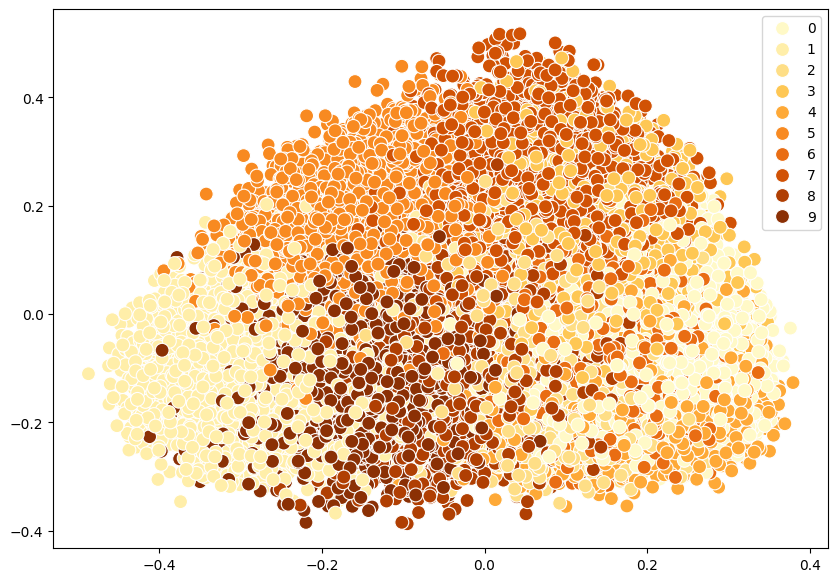

In [35]:
import seaborn as sns

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Визуализация кластеров
plt.figure(figsize=(10, 7))
palette = sns.color_palette('YlOrBr', n_colors=best_k)

sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels, palette=palette, s=100)

In [18]:
seeds = np.array(seeds)

Выведем первые 30 объектов из каждого кластера

In [24]:
unique_labels = np.unique(labels)
class_indices = {label: np.where(labels == label)[0][:30] for label in unique_labels}

for label, indices in class_indices.items():
    print(f'[ Кластер {label + 1} ]')
    print('\n'.join(seeds[indices]))
    print()
    print('-' * 100)
    print()

[ Кластер 1 ]
Как называется фильм в котором детей из детдомв набирают в группу для спец операций??
Как вы находите в себе достаточно терпения, чтобы дочитать те книги, которые вы считаете обязательным для прочтения?
Почему люди стараются владеть чужой собственностью?
Что вы думаете о тренде на индивидуализацию? Что вы понимаете под индивидуализацией обучения и как к этому относитесь?
Ходить ли дома при муже часто голой или нет? Что на это скажите, женщины? Условия для этого есть?
Зачем девушки скрывают друзей в контакте?
Почему парни не любят деревенских женщин? Шугаются от них
Ведёте ли вы личный дневник, какое влияние это оказало на вас, помогло ли в чём-то?
Что чувствует полицейский в конце смены после того, как весь день лупил людей дубиной?
Что если я читаю одно, а произношу совершенно другие слова, независимо от сознания?
Считаете ли вы игры одним из видов исскуств?
Говорят жёлтые цветы дарить , плохая примета. Было ли у кого нибудь, что вам дарили желтые цветы и что то происход

При помощи LLM был охарактеризован каждый кластер:

Вот описание для каждого кластера на основе первых 30 объектов:  

### **Кластер 1**: **"Философские и психологические вопросы о жизни, отношениях и искусстве"**  
(Темы: психология, социология, личные отношения, искусство, самоанализ.)  

### **Кластер 2**: **"Программирование и технические решения: ошибки, алгоритмы, веб-разработка"**  
(Темы: Python, Java, React, базы данных, API, веб-разработка.)  

### **Кластер 3**: **"Юридические и финансовые вопросы: налоги, кредиты, трудовые споры"**  
(Темы: законы, субсидии, кредиты, трудовые договоры, судебные дела.)  

### **Кластер 4**: **"Здоровье, медицина, биология и бытовые советы"**  
(Темы: болезни, животные, питание, космос, химия, DIY.)  

### **Кластер 5**: **"Личные проблемы, карьера, семья и социальные вопросы"**  
(Темы: отношения, работа, дети, самоопределение, кризисы.)  

### **Кластер 6**: **"Программирование и IT: архитектура, базы данных, веб-разработка"**  
(Темы: Python, SQL, WordPress, алгоритмы, API, веб-дизайн.)  

### **Кластер 7**: **"История, политика, общество и глобальные вопросы"**  
(Темы: войны, экономика, религия, наука, культура, будущее.)  

### **Кластер 8**: **"Разнообразные практические и абстрактные вопросы"**  
(Темы: кулинария, наука, психология, IT, искусство, спорт.)  

### **Кластер 9**: **"Техника, гаджеты, игры и DIY-решения"**  
(Темы: ноутбуки, звук, Wi-Fi, игры, телефоны, инженерия.)  

### **Кластер 10**: **"IT, программирование, кибербезопасность и софт"**  
(Темы: Windows, Python, PHP, взломы, Steam, разработка.)  

Каждое название отражает основную тематику кластера. Если нужно уточнить или изменить формулировки — дайте знать!

Можно построить круговой график, чтобы узнать, какая доля данных содержит ту или иную тему

In [27]:
cluster_names = [
    'Философские и психологические вопросы о жизни, отношениях и искусстве',  # 0
    'Программирование и технические решения: ошибки, алгоритмы, веб-разработка',  # 1
    'Юридические и финансовые вопросы: налоги, кредиты, трудовые споры',  # 2
    'Здоровье, медицина, биология и бытовые советы',  # 3
    'Личные проблемы, карьера, семья и социальные вопросы',  # 4
    'Программирование и IT: архитектура, базы данных, веб-разработка',  # 5
    'История, политика, общество и глобальные вопросы',  # 6
    'Разнообразные практические и абстрактные вопросы',  # 7
    'Техника, гаджеты, игры и DIY-решения',  # 8
    'IT, программирование, кибербезопасность и софт'  # 9
]

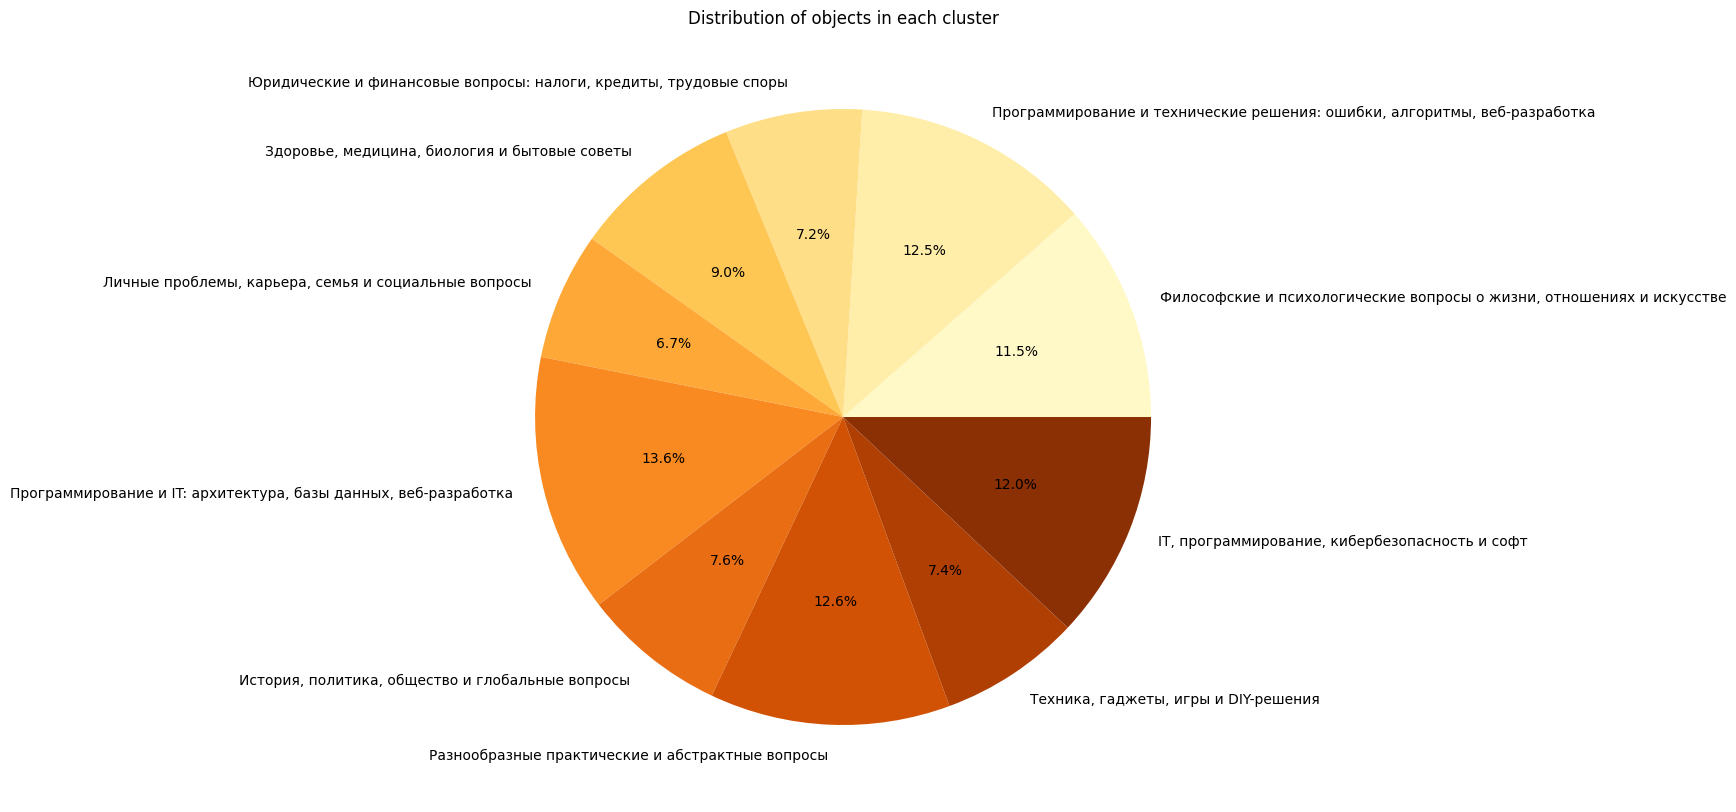

In [37]:
# Подсчёт количества объектов в каждом кластере
unique_labels, counts = np.unique(labels, return_counts=True)

# Построение pie-диаграммы
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(counts, labels=cluster_names, autopct='%1.1f%%', colors=palette)
ax.set_title('Distribution of objects in each cluster')
plt.show()